In [1]:
import sys
sys.path.append('../Codes/')
import numpy as np
import matplotlib.pyplot as plt
from Immuno_models import*
from Bio import Phylo
from io import StringIO
from matplotlib.lines import Line2D
from datetime import datetime, timedelta
import scipy.special as sc
import os.path
import pickle
from matplotlib import style
from scipy.interpolate import interp1d

style.use('seaborn-paper')
print(style.available)
%autosave 60

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


Autosaving every 60 seconds


## Generating Sequences

In [2]:
%%time
n_seq = 400000
#Sequences = generate_Sequences(n_seq)
#pickle.dump( Sequences, open( "../Text_files/Sequences-n_seq-%d.pkl"%(n_seq), "wb" ) )

Sequences = pickle.load( open( "../Text_files/Sequences-n_seq-%d.pkl"%(n_seq), "rb" ) )

#print_raw_file(Sequences, "../Text_files/file2.txt")
#generate_newick_format("../Text_files/file2.txt")


CPU times: user 4.12 s, sys: 415 ms, total: 4.54 s
Wall time: 4.69 s


In [3]:
Sequences[8000].master_sequence, Sequences[8000].sequence, Sequences[8000].hamming_distance, Sequences[8000].energy_parent, Sequences[8000].energy, Sequences[8000].delta_energy


('odsadmgao',
 'mdnbdmgat',
 4,
 -3.1000000000000014,
 -3.1200000000000014,
 -0.01999999999999999)

In [4]:
fig, ax = plt.subplots(1,3,figsize=(30,8))

distances = plot_histogram_hamming_distance(Sequences = Sequences, ax = ax[0])
energies = plot_histogram_energy(Sequences = Sequences, ax = ax[1])
plot_scatter_hamming_distance_energy(distances = distances, energies = energies, ax = ax[2])

fig.savefig('../Figures/Sequences-n_seq-%d.png'%(n_seq))
plt.close()


## Stochastic Simulation

In [34]:
%%time
n_linages = 200
U = n_linages/n_seq
nu = 1.5
R=6
beta = 1
gamma = 1
T = 7
Sub_Sequences = np.random.choice(Sequences, n_linages)
Model = Stochastic_simulation(Sequences = Sub_Sequences, n_linages=n_linages, T = T, U = U, gamma = gamma,
                              nu = nu, R = R, beta = beta, master_Sequence_energy = 12)
Model.Gillespie()


CPU times: user 2.49 s, sys: 158 ms, total: 2.65 s
Wall time: 2.65 s


In [46]:
fig, ax = plt.subplots(3,2,figsize=(20,24))

Model.plot_energy_matrix(ax = ax[0,0])
Model.plot_antigen_time(ax = ax[0,1])
Model.plot_prob_binding(ax = ax[1,0])
Model.stackplot_linages_time(antigen = False, time = True, ax = ax[1,1])
Model.hist_sequences_hamming_distance(Sequences = Sequences, ax = ax[2,0])
Model.hist_sequences_energy(Sequences = Sequences, ax = ax[2,1])


counter = 0
while(os.path.isfile('../Figures/Antigen_Linages_%d.png'%(counter))):
    counter+=1
    
fig.savefig('../Figures/Antigen_Linages_%d.png'%(counter))
plt.close()


In [9]:
fig, ax = plt.subplots(4,2,figsize=(20,32))

for i, k in enumerate([4, 10, 50, 100]):

    biggest_k_linages_freq = Model.plot_k_largest_linages(k=k, ax=ax[i,0])
    Model.plot_entropy_k_largest_linages(k=k, biggest_k_linages_freq = biggest_k_linages_freq, ax=ax[i,1])

counter = 0
while(os.path.isfile('../Figures/Entropy_%d.png'%(counter))):
    counter+=1
    
fig.savefig('../Figures/Entropy_%d.png'%(counter))
plt.close()


In [10]:
Model.activation_time_series.shape

(200, 1168)

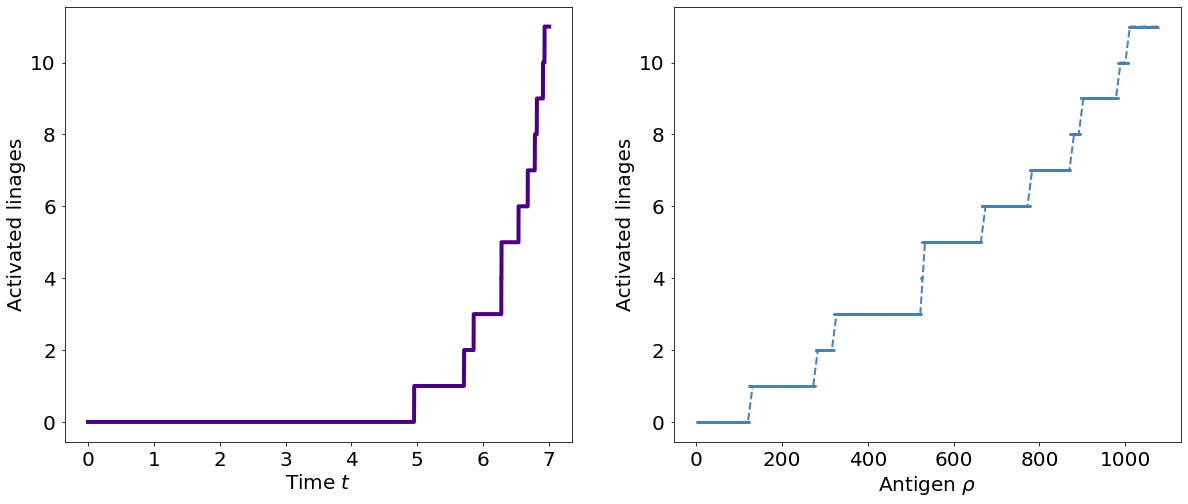

In [28]:
activation_time_series = [np.sum(Model.activation_time_series[:,i]) for i in range(int(len(Model.activation_time_series[0,:])))]
f = interp1d(Model.antigen_time_series, activation_time_series)
x_new = np.linspace(1, np.max(Model.antigen_time_series), 100)
fig, ax = plt.subplots(1,2,figsize=(20,8))

ax[0].plot(Model.time_series, activation_time_series, linewidth = 4, color = 'indigo')
ax[0].set_xlabel(r'Time $t$', fontsize = 20)
ax[0].set_ylabel(r'Activated linages', fontsize = 20)
ax[0].tick_params(labelsize = 20)
#ax[0].set_yscale('log')
#ax[0].legend(loc = 0, fontsize = 20)

ax[1].plot(Model.antigen_time_series, activation_time_series, '.', ms = 5, linewidth = 4, color = 'steelblue')
ax[1].plot(x_new, f(x_new), '--', linewidth = 2, color = 'steelblue')
ax[1].set_xlabel(r'Antigen $\rho$', fontsize = 20)
ax[1].set_ylabel(r'Activated linages', fontsize = 20)
ax[1].tick_params(labelsize = 20)
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
#ax[1].legend(loc = 0, fontsize = 20)



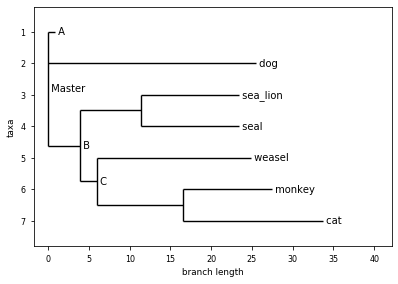

In [21]:
tree = Phylo.read(StringIO("Master(A():0.84600,B((sea_lion:11.99700, seal:12.00300):7.52973,C((monkey:10.85930,cat:17.14069):10.59201, weasel:18.87953):2.09460):3.87382,dog:25.46154):0"), "newick")
tree.ladderize()  # Flip branches so deeper clades are displayed at top
Phylo.draw(tree)

## Ensemble of systems

In [12]:
%%time
n_linages = 200
U = n_linages/n_seq
nu = 0.5
R=6
beta = 1
gamma = 1
T = 6
activated_linages_size = []
activation_time_series_rho = np.zeros(100)
#activation_time_series_t = np.zeros(50)
rho_new = np.linspace(1, 9e2, 100)
#t_new = np.linspace(0, 4, 50)


CPU times: user 523 µs, sys: 300 µs, total: 823 µs
Wall time: 834 µs


In [13]:
%%time
counter = 20
for i in range(counter):
    Sub_Sequences = np.random.choice(Sequences, n_linages)
    Model = Stochastic_simulation(Sequences = Sub_Sequences, n_linages=n_linages, T = T, U = U, gamma = gamma,
                                  nu = nu, R = R, beta = beta, master_Sequence_energy = 12)
    Model.Gillespie()
    print(i, '...')
    activated_linages_size = np.append(activated_linages_size, [Model.linages_time_series[i,-1] for i in range(n_linages) if Model.Sequences[i].active])
    activation_time_series_i = [np.sum(Model.activation_time_series[:,i]) for i in range(int(len(Model.activation_time_series[0,:])))]
    f_rho = interp1d(Model.antigen_time_series, activation_time_series_i)
    #f_t = interp1d(Model.time_series, activation_time_series_i)
    activation_time_series_rho = activation_time_series_rho + f_rho(rho_new)
    #activation_time_series_t = activation_time_series_t + f_t(t_new)
        
activation_time_series_rho = activation_time_series_rho/counter
#activation_time_series_t = activation_time_series_t/counter
print(counter)


0 ...
1 ...
2 ...
3 ...
4 ...
5 ...
6 ...
7 ...
8 ...
9 ...
10 ...
11 ...
12 ...
13 ...
14 ...
15 ...
16 ...
17 ...
18 ...
19 ...
20
CPU times: user 1min 28s, sys: 10 s, total: 1min 38s
Wall time: 1min 39s


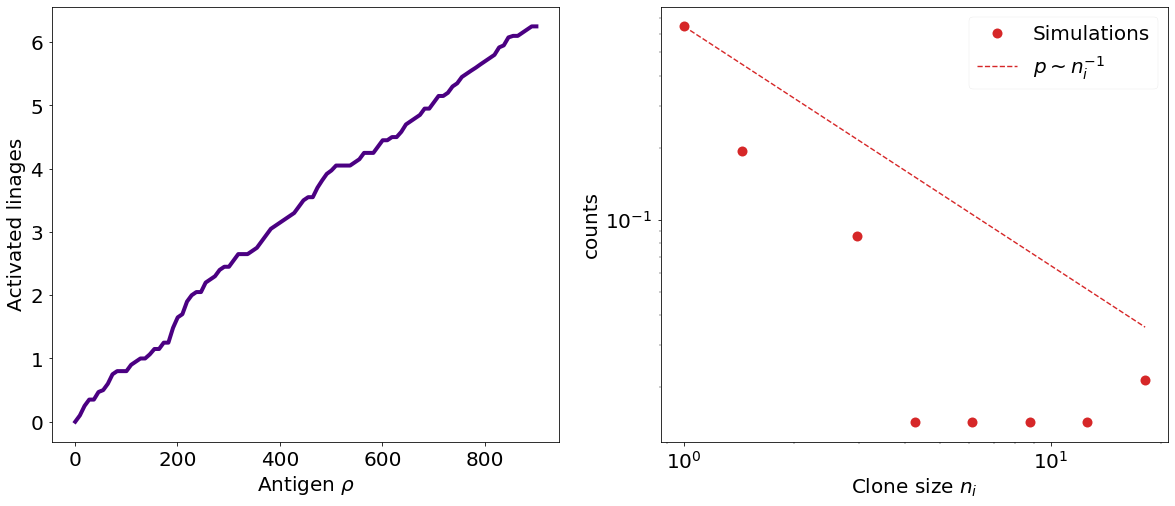

In [14]:
fig, ax = plt.subplots(1,2,figsize=(20,8))

ax[0].plot(rho_new, activation_time_series_rho, '-', ms = 5, linewidth = 4, color = 'indigo')
ax[0].set_xlabel(r'Antigen $\rho$', fontsize = 20)
ax[0].set_ylabel(r'Activated linages', fontsize = 20)
ax[0].tick_params(labelsize = 20)
#ax[0].set_xscale('log')
#ax[0].set_yscale('log')
#ax[0].legend(loc = 0, fontsize = 20)

#________________________________________________________________________________________
data_activated_linages = np.histogram(activated_linages_size, bins = np.logspace(0,np.log10(np.max(activated_linages_size)),10))
#ax[1].plot(data_activated_linages[1][:-1], np.cumsum(data_activated_linages[0]), marker = '.', ms = 20, linestyle = '--', linewidth = 4, color = 'tab:red')
ax[1].plot(data_activated_linages[1][:-1], data_activated_linages[0]/np.sum(data_activated_linages[0]), marker = '.', ms = 20, linestyle = '', linewidth = 4, color = 'tab:red', label = 'Simulations')
ax[1].plot(data_activated_linages[1][:-1], (data_activated_linages[0][0]/np.sum(data_activated_linages[0]))*(data_activated_linages[1][:-1])**(-1), linestyle = '--', color = 'tab:red', label = r'$p\sim n_i^{-1}$')
ax[1].set_xlabel(r'Clone size $n_i$', fontsize = 20)
ax[1].set_ylabel(r'counts', fontsize = 20)
ax[1].tick_params(labelsize = 20)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].legend(loc = 0, fontsize = 20)

counter = 0
while(os.path.isfile('../Figures/Linages_size_distribution_%d.png'%(counter))):
    counter+=1
    
#fig.savefig('../Figures/Linages_size_distribution_%d.png'%(counter))
#plt.close()
